In [21]:
'''
Panels of Figure 1: Behaviour of mice in Gambling task
The behaviour is based on the next table:
# Info Columns BehData:
# 0- Trial Start
# 1- Trial End
# 2- Duration (Seconds)
# 3- Block
# 4- Gamble Arm (Right = 1, Left = 0)
# 5- Probability big Reward
# 6- Probability Small Reward
# 7- Ammount Big Reward
# 8- Ammount Small Reward
# 9- Number of previously wheel not stopping
# 10- Not responding Trial
# 11- Chosen Side (Right = 1, Left = 0)
# 12- Chosen Arm (Gamble = 1, Safe = 0)
# 13- Reward Given
# 14- Start of the trial (Sampling points)
# 15- Cue Presentation (Sampling Points)
# 16- Start of the response window (Sampling Points)
# 17- Reward Period (Sampling Points)
# 18- End of the trial

In this code there are the next plots:
1) Example of the behaviour for a specific session
2) Boxplot of the choice gamble side in each probability block
'''


#%% Libraries
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
plt.rcParams['font.size'] = 20

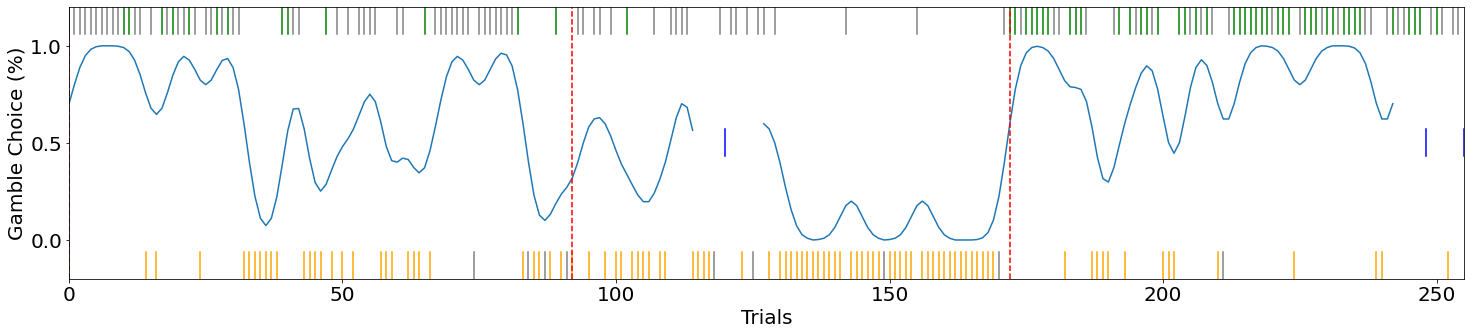

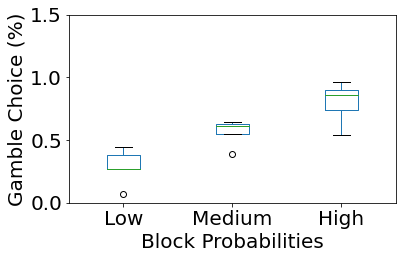

In [41]:

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Plot Behaviour %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

path='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/DM01_7_220524'   # Pathway of the data (behaviour & Spike activity)

# Selection of the file
os.chdir(path)
list_files = os.listdir(path)
for i in list_files:
    if i.find('Behaviour')>0:
        Behaviour_name = i

# Load data
# Open the Behaviour file
Bdata = scipy.io.loadmat(Behaviour_name)
BehData = Bdata[list(Bdata.keys())[-1]]

# Classification of trials following the behabiour
GambleRewardTrials = np.where((BehData[:,12]==1) & (BehData[:,13]==1))[0]
GambleNoRewardTrials =  np.where((BehData[:,12]==1) & (BehData[:,13]==0))[0]
SafeRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==1))[0]
SafeNoRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==0))[0]
NoRespondingTrials = np.where(BehData[:,10]==1)[0]

# Blocks
Block_Prob = np.unique(BehData[:,5])
BlockTrials = [np.where(Block_Prob[i]==BehData[:,5])[0][0] for i in range(len(Block_Prob))]
# Smoothing the data for plotting
ScaleDecision=BehData[:,12]+(BehData[:,12]-1)
SigmaDecision=1
Binx =0.5
KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
DecisionConvolution=np.convolve(ScaleDecision,KernelDecision,mode='same')
DecisionNormalized=(DecisionConvolution/np.nanmax(np.abs(DecisionConvolution))+1)/2
if NoRespondingTrials[0]<20:
    first_trial = NoRespondingTrials[0]+1
    last_trial = NoRespondingTrials[1]-1
else:
    first_trial = 0
    last_trial = NoRespondingTrials[0]-1
    
first_trial = 0
last_trial = NoRespondingTrials[3]-1

# FIGURE: Plot behaviour performance
plt.figure(figsize=(25,5))
plt.plot(DecisionNormalized)
for i in GambleRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='g') 
for i in GambleNoRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='gray')
for i in SafeRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='orange')
for i in SafeNoRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='gray')
for i in NoRespondingTrials:
    plt.axvline(i,ymin=0.45,ymax=0.55,color='blue')
for i in BlockTrials:
    plt.axvline(i,linestyle='dashed',color='r',)     
plt.ylim([-0.2,1.2])
plt.yticks(ticks=[1.0,0.5,0.0])
plt.xlim([first_trial,last_trial])
plt.xlabel('Trials')
plt.ylabel("Gamble Choice (%)")
plt.savefig("D:/_work_cestarellas/Analysis/Pack_Daniel_project/Figures/1_Figure/Behaviour_DM01_07.png")
plt.show()

#%% Statistic Behaviour

path='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/'
os.chdir(path)
list_sessions = os.listdir(path)
choice_session = []
for k in list_sessions:
    session_path=os.path.join(path,k)
    os.chdir(session_path)
    list_files = os.listdir(session_path)
    for i in list_files:
        if i.find('Behaviour')>0:
            Behaviour_name = i
    Bdata = scipy.io.loadmat(Behaviour_name)
    BehData = Bdata[list(Bdata.keys())[-1]]
    
    block_info=np.sort(np.unique(BehData[:,5]))
    blocks_num=len(block_info)
    ratio_g = []
    for i in range(blocks_num):
        Choice=BehData[block_info[i]==BehData[:,5],12]
        Choice = Choice[BehData[block_info[i]==BehData[:,5],10]==0]
        ratio_g.append(np.sum(Choice)/len(Choice))
    choice_session.append(ratio_g)

ratio_sessions = np.array(choice_session)
Choice_df = pd.DataFrame({"Session":list_sessions,"Low":ratio_sessions[:,0],
                            "Medium":ratio_sessions[:,1],
                            "High": ratio_sessions[:,2]})

Choice_df = Choice_df.set_index("Session")

plt.figure()
box=Choice_df.boxplot(column=["Low","Medium","High"],grid=False)
plt.ylim([0,1.5])
plt.ylabel("Gamble Choice (%)")
plt.xlabel("Block Probabilities")
plt.tight_layout()
plt.savefig("D:/_work_cestarellas/Analysis/Pack_Daniel_project/Figures/1_Figure/Block_probabilities_session.pdf")
plt.show()
# %%

In [35]:
# Perform one-way ANOVA
anova_result = f_oneway(Choice_df['Low'],Choice_df['Medium'],Choice_df['High'])

# Print the ANOVA result
print("ANOVA F-value:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Perform Tukey's HSD test for multiple comparisons
all_values = pd.concat([Choice_df['Low'], Choice_df['Medium'], Choice_df['High']])
all_groups = ['Low'] * len(Choice_df['Low']) + ['Medium'] * len(Choice_df['Medium']) + ['High'] * len(Choice_df['High'])

tukey_results = pairwise_tukeyhsd(all_values, all_groups)
print(tukey_results)



ANOVA F-value: 16.772451676540364
ANOVA p-value: 0.0003345405505522064
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  High    Low  -0.5145 0.0002 -0.7517 -0.2772   True
  High Medium  -0.2358 0.0515  -0.473  0.0015  False
   Low Medium   0.2787 0.0218  0.0414  0.5159   True
----------------------------------------------------
